In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
# svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
# logistic regression
from sklearn.linear_model import LogisticRegression
import shap
# kfold cross validation
from sklearn.model_selection import KFold

import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, accuracy_score
from numpy import interp
from numpy import linspace

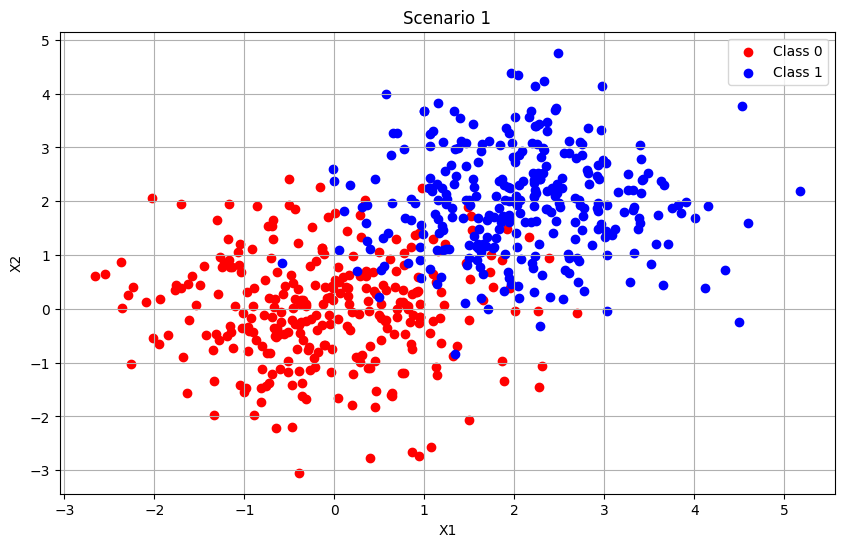

In [2]:
# Scenario 1
np.random.seed(0)
n = 300
mean = [0, 0]
cov = [[1, 0], [0, 1]]
X1 = np.random.multivariate_normal(mean, cov, n)
y1 = np.zeros(n)

mean = [2, 2]
cov = [[1, 0], [0, 1]]
X2 = np.random.multivariate_normal(mean, cov, n)
y2 = np.ones(n)

X_s1 = np.concatenate((X1, X2))
y_s1 = np.concatenate((y1, y2))

plt.figure(figsize=(10, 6))
plt.scatter(X1[:, 0], X1[:, 1], color="r", label="Class 0")
plt.scatter(X2[:, 0], X2[:, 1], color="b", label="Class 1")
plt.title("Scenario 1")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.show()

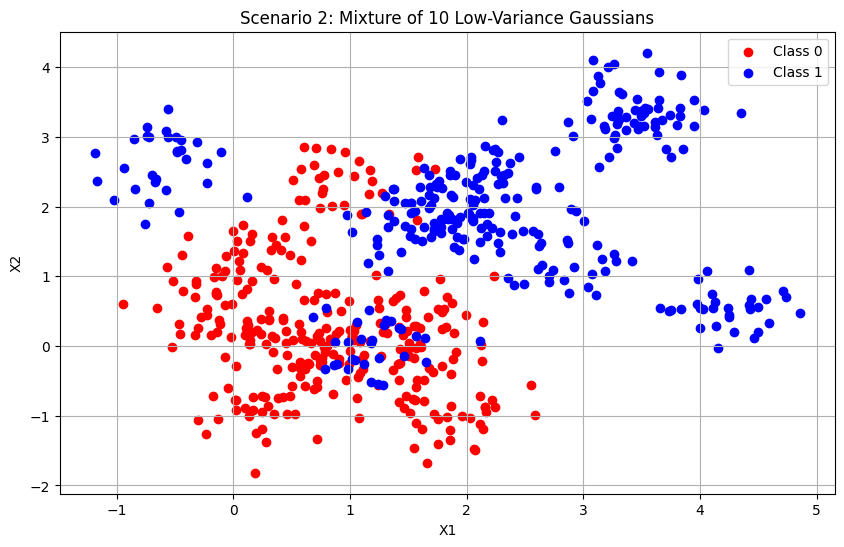

In [3]:
# Scenario 2: Mixture of 10 low-variance Gaussians
np.random.seed(0)
n = 300 
n_gaussians = 10 
low_variance = [[0.1, 0], [0, 0.1]]  # low variance

# distribution of means
meta_mean_class_1 = [0, 0]
meta_cov_class_1 = [[1, 0], [0, 1]]
meta_mean_class_2 = [2, 2]
meta_cov_class_2 = [[1, 0], [0, 1]]

# Generate means for the Gaussian components
means_class_1 = np.random.multivariate_normal(meta_mean_class_1, meta_cov_class_1, n_gaussians)
means_class_2 = np.random.multivariate_normal(meta_mean_class_2, meta_cov_class_2, n_gaussians)

# Generate data for each mixture component
X1 = np.vstack([np.random.multivariate_normal(mean, low_variance, n // n_gaussians) for mean in means_class_1])
X2 = np.vstack([np.random.multivariate_normal(mean, low_variance, n // n_gaussians) for mean in means_class_2])

y1 = np.zeros(X1.shape[0])
y2 = np.ones(X2.shape[0])

X_s2 = np.concatenate((X1, X2))
y_s2 = np.concatenate((y1, y2))

# Plotting the generated data
plt.figure(figsize=(10, 6))
plt.scatter(X1[:, 0], X1[:, 1], color="red", label="Class 0")
plt.scatter(X2[:, 0], X2[:, 1], color="blue", label="Class 1")
plt.title("Scenario 2: Mixture of 10 Low-Variance Gaussians")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.show()

# 6 Using Scenarios 1 and 2 use kfold cross validation and fit a SVM (linear and radial kernel) and Logistic Regression
to the training set. What test error
rate do you obtain for all algorithms? Draw the ROC curve for all the classifiers (each graph
should represent the k-fold cross validation)

In [4]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
models = {
    "SVM Linear": SVC(kernel="linear", probability=True),
    "SVM RBF": SVC(kernel="rbf", probability=True),
    "Logistic Regression": LogisticRegression(solver='liblinear')
}

# Cross-validation and ROC data collection
results = {name: {"accuracy": [], "auc": [], "fpr": [], "tpr": []} for name in models.keys()}
base_fpr = linspace(0, 1, 101)  # Common threshold scale for ROC

for train_index, test_index in kf.split(X_s1, y_s1):
    X_train, X_test = X_s1[train_index], X_s1[test_index]
    y_train, y_test = y_s1[train_index], y_s1[test_index]

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)
        
        accuracy = accuracy_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = auc(fpr, tpr)
        
        results[name]["accuracy"].append(accuracy)
        results[name]["auc"].append(auc_score)
        results[name]["fpr"].append(fpr)
        results[name]["tpr"].append(tpr)



# Print out the results
for name, data in results.items():
    print(f"{name}:")

    print(f"  Average Test Error Rate: {100 - np.mean(data['accuracy'])*100:.2f}%")
    print(f"  Average AUC: {np.mean(data['auc']):.2f}")


SVM Linear:
  Average Test Error Rate: 7.83%
  Average AUC: 0.98
SVM RBF:
  Average Test Error Rate: 7.50%
  Average AUC: 0.97
Logistic Regression:
  Average Test Error Rate: 7.83%
  Average AUC: 0.98


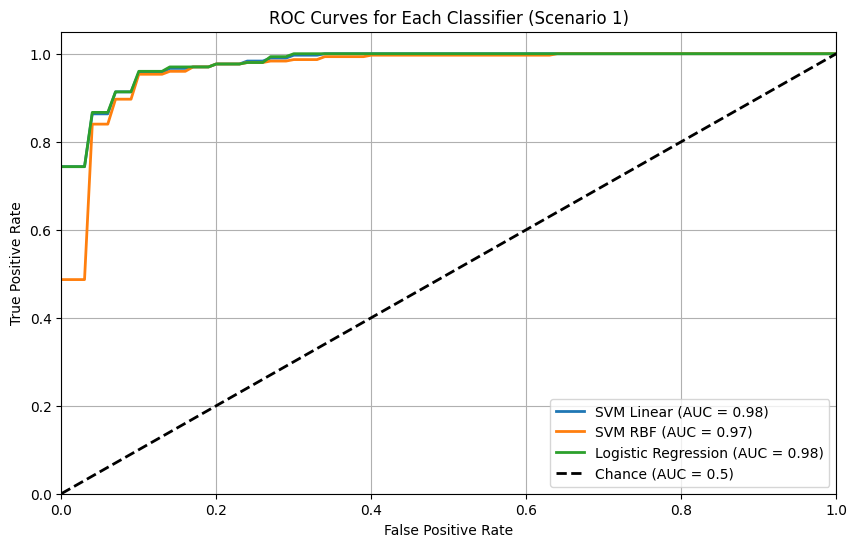

In [5]:
# Calculating mean TPR/FPR and AUC for plotting
plt.figure(figsize=(10, 6))
for name, data in results.items():
    mean_tpr = np.mean([interp(base_fpr, fpr, tpr) for fpr, tpr in zip(data['fpr'], data['tpr'])], axis=0)
    mean_tpr[-1] = 1.0  # Ensure the curve goes to (1,1)
    roc_auc = auc(base_fpr, mean_tpr)
    plt.plot(base_fpr, mean_tpr, label=f'{name} (AUC = {roc_auc:.2f})', lw=2)

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Classifier (Scenario 1)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [6]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
models = {
    "SVM Linear": SVC(kernel="linear", probability=True),
    "SVM RBF": SVC(kernel="rbf", probability=True),
    "Logistic Regression": LogisticRegression(solver='liblinear')
}

# Cross-validation and ROC data collection
results = {name: {"accuracy": [], "auc": [], "fpr": [], "tpr": []} for name in models.keys()}
base_fpr = linspace(0, 1, 101)  # Common threshold scale for ROC

for train_index, test_index in kf.split(X_s2, y_s2):
    X_train, X_test = X_s2[train_index], X_s2[test_index]
    y_train, y_test = y_s2[train_index], y_s2[test_index]

    for name, model in models.items():
        model.fit(X_train, y_train)
        y_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc_score = auc(fpr, tpr)

        results[name]["accuracy"].append(accuracy)
        results[name]["auc"].append(auc_score)
        results[name]["fpr"].append(fpr)
        results[name]["tpr"].append(tpr)

# Print out the results
for name, data in results.items():
    print(f"{name}:")

    print(f"  Average Test Error Rate: {100 - np.mean(data['accuracy']) * 100:.2f}%")
    print(f"  Average AUC: {np.mean(data['auc']):.2f}")

SVM Linear:
  Average Test Error Rate: 12.17%
  Average AUC: 0.92
SVM RBF:
  Average Test Error Rate: 8.17%
  Average AUC: 0.96
Logistic Regression:
  Average Test Error Rate: 13.50%
  Average AUC: 0.92


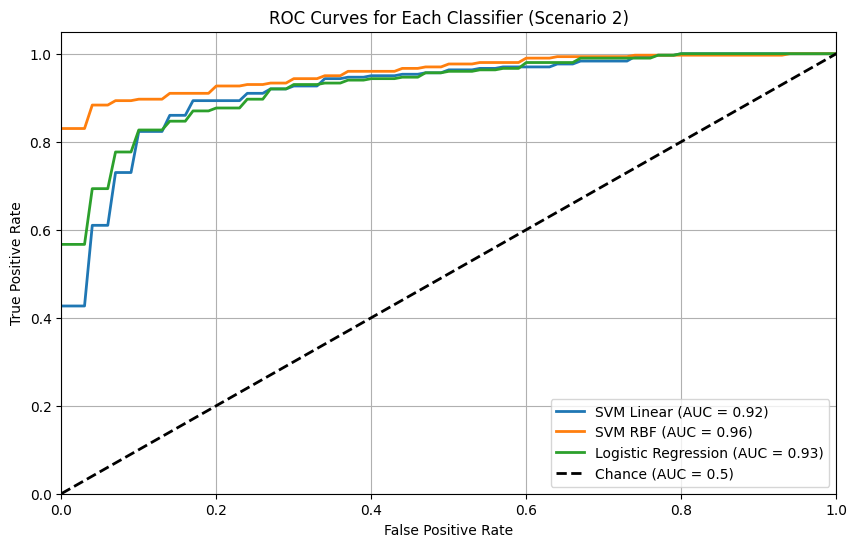

In [7]:

# Calculating mean TPR/FPR and AUC for plotting
plt.figure(figsize=(10, 6))
for name, data in results.items():
    mean_tpr = np.mean([interp(base_fpr, fpr, tpr) for fpr, tpr in zip(data['fpr'], data['tpr'])], axis=0)
    mean_tpr[-1] = 1.0  # Ensure the curve goes to (1,1)
    roc_auc = auc(base_fpr, mean_tpr)
    plt.plot(base_fpr, mean_tpr, label=f'{name} (AUC = {roc_auc:.2f})', lw=2)

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Classifier (Scenario 2)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# 7 FOr the SVM visualize the support vectors (i.e. plot with different colors) as well as the decision boundary


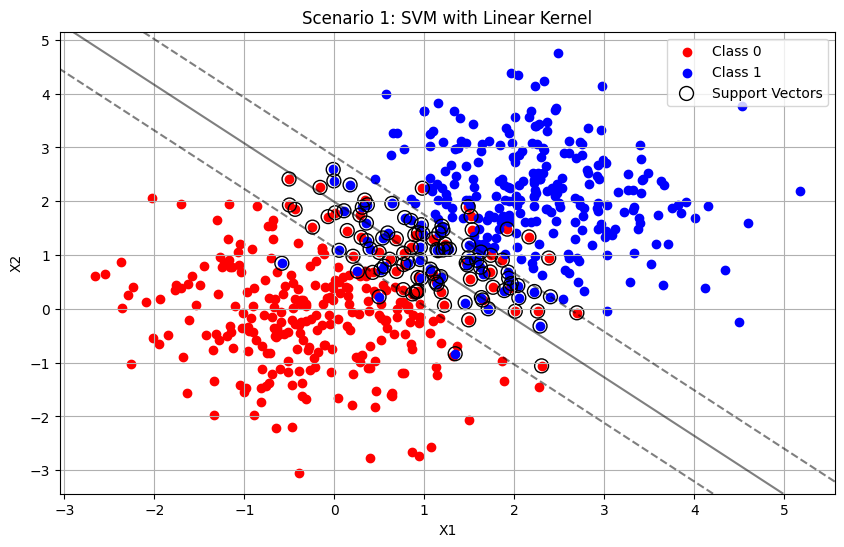

In [8]:
# Scenario 1

# Scenario 1
np.random.seed(0)
n = 300
mean = [0, 0]
cov = [[1, 0], [0, 1]]
X1 = np.random.multivariate_normal(mean, cov, n)
y1 = np.zeros(n)

mean = [2, 2]
cov = [[1, 0], [0, 1]]
X2 = np.random.multivariate_normal(mean, cov, n)
y2 = np.ones(n)

X_s1 = np.concatenate((X1, X2))
y_s1 = np.concatenate((y1, y2))
model = SVC(kernel="linear")
model.fit(X_s1, y_s1)

plt.figure(figsize=(10, 6))
plt.scatter(X1[:, 0], X1[:, 1], color="r", label="Class 0")
plt.scatter(X2[:, 0], X2[:, 1], color="b", label="Class 1")

# Plotting the support vectors
plt.scatter(model.support_vectors_[:, 0], model.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k', label="Support Vectors")

# Plotting the decision boundary
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = model.decision_function(xy).reshape(XX.shape)

ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

plt.title("Scenario 1: SVM with Linear Kernel")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.show()

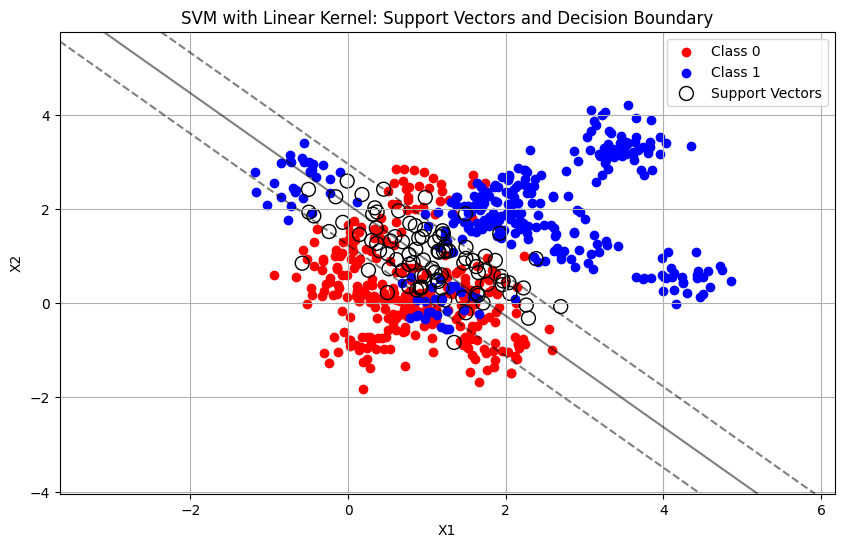

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.svm import SVC

np.random.seed(0)
n = 300 
n_gaussians = 10 
low_variance = [[0.1, 0], [0, 0.1]]  # low variance

# distribution of means
meta_mean_class_1 = [0, 0]
meta_cov_class_1 = [[1, 0], [0, 1]]
meta_mean_class_2 = [2, 2]
meta_cov_class_2 = [[1, 0], [0, 1]]

# Generate means for the Gaussian components
means_class_1 = np.random.multivariate_normal(meta_mean_class_1, meta_cov_class_1, n_gaussians)
means_class_2 = np.random.multivariate_normal(meta_mean_class_2, meta_cov_class_2, n_gaussians)

# Generate data for each mixture component
X1 = np.vstack([np.random.multivariate_normal(mean, low_variance, n // n_gaussians) for mean in means_class_1])
X2 = np.vstack([np.random.multivariate_normal(mean, low_variance, n // n_gaussians) for mean in means_class_2])

y1 = np.zeros(X1.shape[0])
y2 = np.ones(X2.shape[0])

X_s2 = np.concatenate((X1, X2))
y_s2 = np.concatenate((y1, y2))

# Setup for cross-validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)
train_index, test_index = next(kf.split(X_s1, y_s1))
X_train, X_test = X_s1[train_index], X_s1[test_index]
y_train, y_test = y_s1[train_index], y_s1[test_index]

# SVM with Linear kernel
svm_linear = SVC(kernel="linear")
svm_linear.fit(X_train, y_train)

# Retrieve support vectors
support_vectors = svm_linear.support_vectors_

# Create a grid to evaluate model
xx, yy = np.meshgrid(np.linspace(X_s1[:, 0].min()-1, X_s1[:, 0].max()+1, 500),
                     np.linspace(X_s1[:, 1].min()-1, X_s1[:, 1].max()+1, 500))

# Plot the decision function
Z = svm_linear.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plotting
plt.figure(figsize=(10, 6))
plt.contour(xx, yy, Z, levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'], colors='k')
plt.scatter(X1[:, 0], X1[:, 1], color="r", label="Class 0")
plt.scatter(X2[:, 0], X2[:, 1], color="b", label="Class 1")
plt.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
            linewidth=1, facecolors='none', edgecolors='k', label="Support Vectors")
plt.title("SVM with Linear Kernel: Support Vectors and Decision Boundary")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)
plt.show()


# 12 Research how you can you use SHAP to explain the results of SVM?

# 13 Perform an analysis for the Spam dataset (widely used in ESLII) using
SVM and logistic regression. Compare the results.

features: 


crl.tot		Total length of uninterrupted sequences of capitals


dollar		Occurrences of the dollar sign, as percent of total number of characters


bang		Occurrences of ‘!’, as percent of total number of characters


money		Occurrences of ‘money’, as percent of total number of characters


n000		Occurrences of the string ‘000’, as percent of total number of words


make		Occurrences of ‘make’, as a percent of total number of words


yesno		Outcome variable, a factor with levels 'n' not spam, 'y' spam

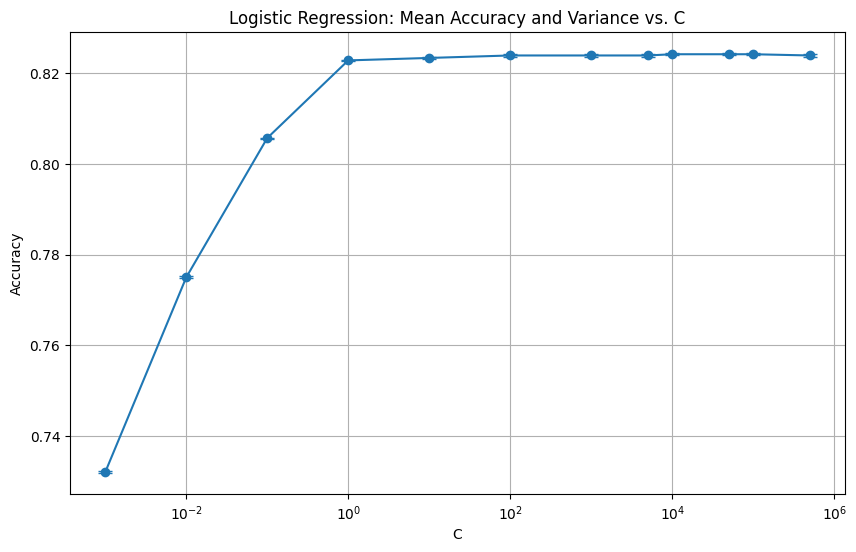

In [26]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
df = pd.read_csv("spam.csv")

X = df.drop(columns=["yesno"])
y = df["yesno"]
y = y.replace({"n": 0, "y": 1})

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


# Kfold to find best C value plot mean accuracy and variance
kf = KFold(n_splits=5, shuffle=True, random_state=0)
C_values = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 5000, 10000, 50000, 100_000, 500_000]
mean_accuracy = []
var_accuracy = []

for C in C_values:
    accuracies = []
    for train_index, test_index in kf.split(X_train, y_train):
        X_train_kf, X_test_kf = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_kf, y_test_kf = y_train.iloc[train_index], y_train.iloc[test_index]

        model = LogisticRegression(C=C, solver='liblinear')
        model.fit(X_train_kf, y_train_kf)
        y_pred = model.predict(X_test_kf)
        accuracies.append(accuracy_score(y_test_kf, y_pred))

    mean_accuracy.append(np.mean(accuracies))
    var_accuracy.append(np.var(accuracies))
    
plt.figure(figsize=(10, 6))
plt.errorbar(C_values, mean_accuracy, yerr=var_accuracy, fmt='o-', capsize=5)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("Logistic Regression")
plt.grid(True)
plt.show()


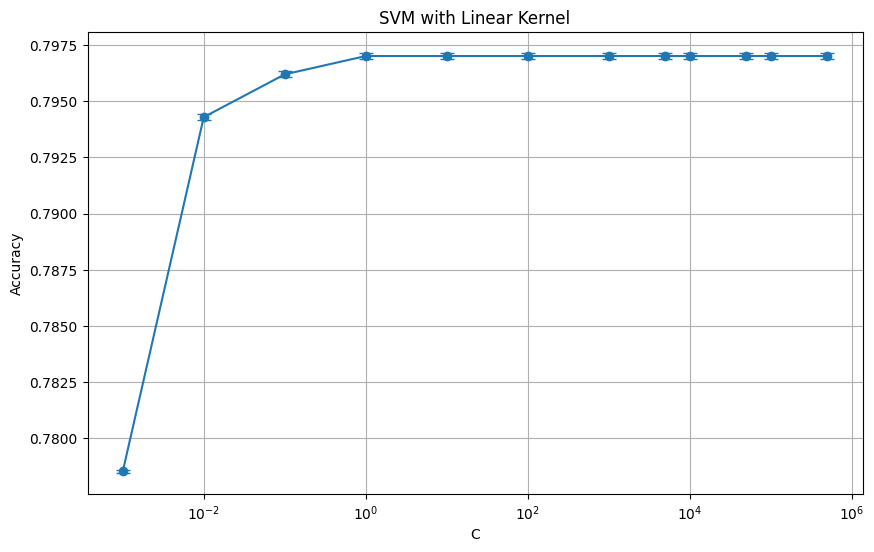

In [27]:
# same for svm
from sklearn.svm import LinearSVC
mean_accuracy = []
var_accuracy = []

for C in C_values:
    accuracies = []
    for train_index, test_index in kf.split(X_train, y_train):
        X_train_kf, X_test_kf = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_kf, y_test_kf = y_train.iloc[train_index], y_train.iloc[test_index]
        
        model = make_pipeline(StandardScaler(), LinearSVC(C=C, dual=False, max_iter=10000))
        #model = LinearSVC(C=C, dual=False, max_iter=10000)
        model.fit(X_train_kf, y_train_kf)
        y_pred = model.predict(X_test_kf)
        accuracies.append(accuracy_score(y_test_kf, y_pred))

    mean_accuracy.append(np.mean(accuracies))
    var_accuracy.append(np.var(accuracies))
    
plt.figure(figsize=(10, 6))
plt.errorbar(C_values, mean_accuracy, yerr=var_accuracy, fmt='o-', capsize=5)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("SVM with Linear Kernel")
plt.grid(True)
plt.show()

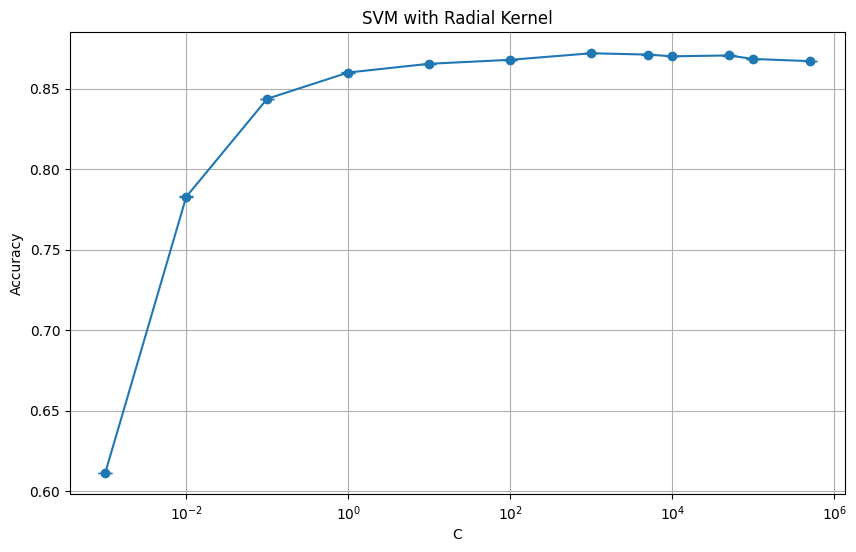

In [28]:

mean_accuracy = []
var_accuracy = []

for C in C_values:
    accuracies = []
    for train_index, test_index in kf.split(X_train, y_train):
        X_train_kf, X_test_kf = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_kf, y_test_kf = y_train.iloc[train_index], y_train.iloc[test_index]

        model = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=C, probability=False))
        #model = SVC(kernel="rbf", C=C, probability=False)
        model.fit(X_train_kf, y_train_kf)
        y_pred = model.predict(X_test_kf)
        accuracies.append(accuracy_score(y_test_kf, y_pred))

    mean_accuracy.append(np.mean(accuracies))
    var_accuracy.append(np.var(accuracies))
    
plt.figure(figsize=(10, 6))
plt.errorbar(C_values, mean_accuracy, yerr=var_accuracy, fmt='o-', capsize=5)
plt.xscale("log")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.title("SVM with Radial Kernel")
plt.grid(True)
plt.show()

In [32]:
# logistic regression C = 1
# svm linear C = 1
# svm rbf C = 100_000

# train the models
logistic_model = LogisticRegression(C=1, solver='liblinear')
logistic_model.fit(X_train, y_train)

svm_linear_model = make_pipeline(StandardScaler(), LinearSVC(C=1, dual=False, max_iter=10000))
svm_linear_model.fit(X_train, y_train)

svm_rbf_model = make_pipeline(StandardScaler(), SVC(kernel="rbf", C=1000, probability=True))
svm_rbf_model.fit(X_train, y_train)



Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(C=1000, probability=True))])

In [33]:
# get accuracies and confusion matrices
models = {
    "Logistic Regression": logistic_model,
    "SVM Linear": svm_linear_model,
    "SVM RBF": svm_rbf_model
}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    confusion = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    
    print(f"{name}:")
    print(f"  Accuracy: {accuracy:.2f}")
    print(f"  Confusion Matrix:")
    print(confusion)
    print(f"  Classification Report:")
    print(report)
    print()


Logistic Regression:
  Accuracy: 0.82
  Confusion Matrix:
[[509  29]
 [134 249]]
  Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.95      0.86       538
           1       0.90      0.65      0.75       383

    accuracy                           0.82       921
   macro avg       0.84      0.80      0.81       921
weighted avg       0.83      0.82      0.82       921


SVM Linear:
  Accuracy: 0.79
  Confusion Matrix:
[[510  28]
 [163 220]]
  Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.95      0.84       538
           1       0.89      0.57      0.70       383

    accuracy                           0.79       921
   macro avg       0.82      0.76      0.77       921
weighted avg       0.81      0.79      0.78       921


SVM RBF:
  Accuracy: 0.86
  Confusion Matrix:
[[507  31]
 [ 96 287]]
  Classification Report:
              precision    recall  f1-score   s

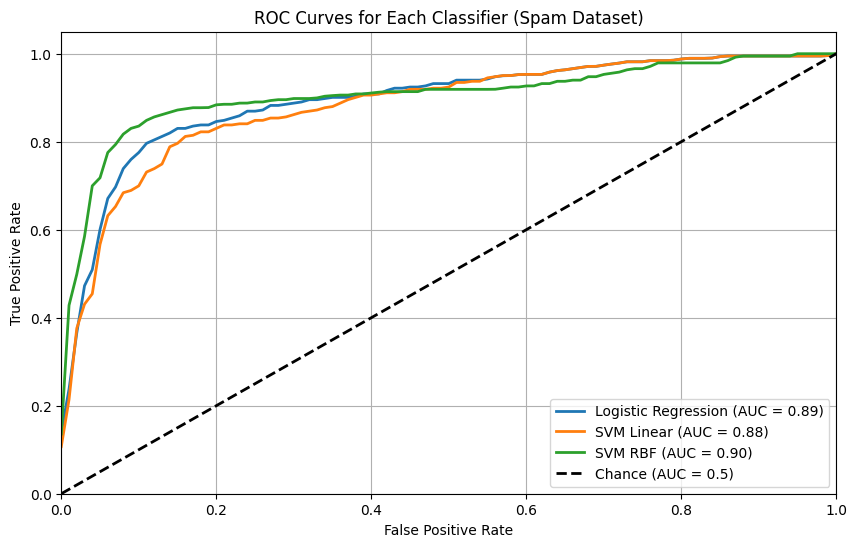

In [34]:
# ROC curve
models = {
    "Logistic Regression": logistic_model,
    "SVM Linear": svm_linear_model,
    "SVM RBF": svm_rbf_model
}

results = {name: {"accuracy": [], "auc": [], "fpr": [], "tpr": []} for name in models.keys()}
base_fpr = linspace(0, 1, 101)  # Common threshold scale for ROC

for name, model in models.items():
    model.fit(X_train, y_train)
    y_prob = model.decision_function(X_test) if name == "SVM Linear" else model.predict_proba(X_test)[:, 1]
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc_score = auc(fpr, tpr)

    results[name]["accuracy"].append(accuracy)
    results[name]["auc"].append(auc_score)
    results[name]["fpr"].append(fpr)
    results[name]["tpr"].append(tpr)
    
# plot ROC curve
plt.figure(figsize=(10, 6))
for name, data in results.items():
    mean_tpr = np.mean([interp(base_fpr, fpr, tpr) for fpr, tpr in zip(data['fpr'], data['tpr'])], axis=0)
    mean_tpr[-1] = 1.0  # Ensure the curve goes to (1,1)
    roc_auc = auc(base_fpr, mean_tpr)
    plt.plot(base_fpr, mean_tpr, label=f'{name} (AUC = {roc_auc:.2f})', lw=2)
    
plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Classifier (Spam Dataset)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

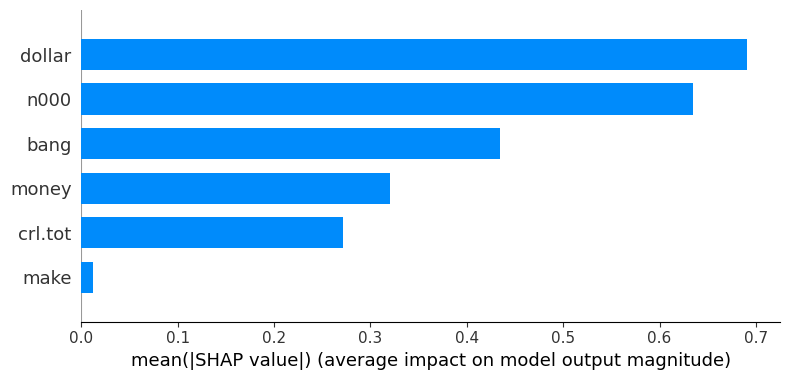

In [35]:
# shap

# Logistic Regression
explainer = shap.Explainer(logistic_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

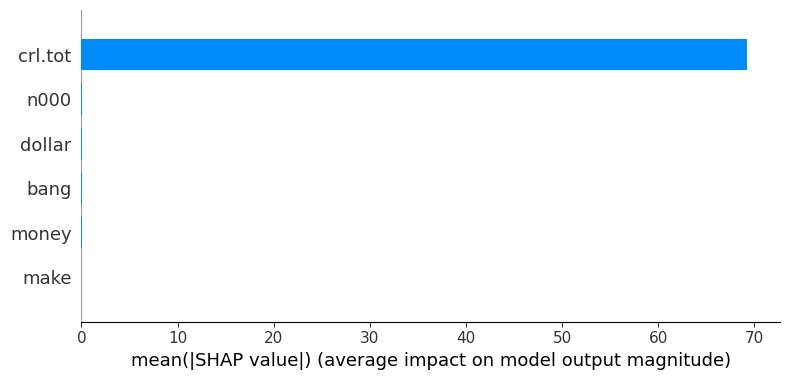

In [37]:
# SVM Linear
explainer = shap.Explainer(svm_linear_model[1], X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, plot_type="bar")

C:\environments\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\environments\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\environments\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\environments\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\environments\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\environments\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\environments\Lib\site-packages\sklearn\base.py:458: UserWarning: X has feature names, but SVC was fitted without fe

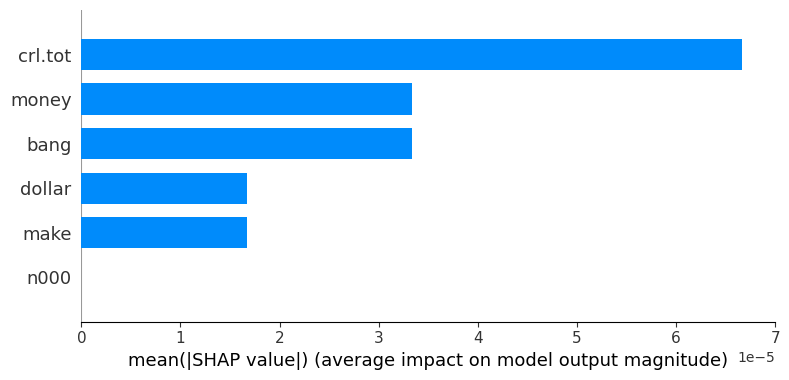

In [43]:
# SVM RBF use shap.sample
explainer = shap.Explainer(svm_rbf_model[1].predict, shap.sample(X_train, 100))
shap_values = explainer(shap.sample(X_test, 100))
shap.summary_plot(shap_values, shap.sample(X_test, 100), plot_type="bar")